### GD-VAE: Constrained Mechanics
[http://atzberger.org](http://atzberger.org)

#### Overview

We develop variational autoencoders for dimension reduction of data from a constrained mechanical system. This trains models for embedding data within a manifold latent space with prescribed topology and geometry. The manifold is specified by a point cloud representation allowing for flexibility in the specified geometry. When analytic expressions are known these also can be used. For more information see the GD-VAEs paper.

#### Arm Mechanics

Consider a robotics arm consisting of two rod segments in a 2D space. The arm configuration are given by the locations $x_1, x_2 \in \mathbb{R}^2$.  In the rigid case the state of the system could in principle be represented by two angles $\theta_1$ and $\theta_2$ in $[0,2\pi]$. However, using angles as latent representations can be problematic in practice since the angle variables can jump discontinuously between $0$ and $2\pi$ when representing configurations. We instead use a 2Dx2D latent structure in $\mathbb{R}^4$. We can map this to $2$ Degrees of Freedom (DOF) while avoiding coordinate singularities by using a manifold latent space.

In the case of rigid rods, the periodicity results in the configurations mapping naturally to a torus manifold. More exotic mechanical constraints can also be considered such as configurations of the arm lengths resulting in points $x_1$ and $x_2$ being on a klein bottle.  For a figure illustrating the arm geometry see the examples folder or paper.

In [1]:
import torch,os,sys,pickle,time,shutil,logging,numpy as np,matplotlib,matplotlib.pyplot as plt;
import gd_vae_pytorch as gd_vae,gd_vae_pytorch.geo_map,gd_vae_pytorch.vae;
import gd_vae_pytorch.nn,gd_vae_pytorch.utils; 

# local packages
sys.path.insert(1,'.');
import pkg,pkg.datasets,pkg.vis,pkg.geometry,pkg.model_utils;

# script name without extension
script_base_name = 'arm_mechanics1'; 

#### Parameters 

In [2]:
# setup the parameters
batch_size = int(1e3); # int(1e2);
flag_save_fig = True;

# select dataset
#flag_dataset = 'arm1_torus';
flag_dataset = 'arm1_klein';
if flag_dataset == 'arm1_torus':  
  num_dim_x = 4;   

  # select model
  flag_model = 'gd_vae_nn1_torus';
  #flag_model = 'gd_vae_nn1_R_n';
  if flag_model == 'gd_vae_nn1_torus':
    num_dim_z = 4; 
  else:
    num_dim_z = 10; # R^n case any value fine

elif flag_dataset == 'arm1_klein':
  num_dim_x = 4;      

  # select model
  flag_model = 'gd_vae_nn1_klein';
  #flag_model = 'gd_vae_nn1_R_n';  
  if flag_model == 'gd_vae_nn1_klein':
    num_dim_z = 4; 
  else:
    num_dim_z = 10; # R^n case any value fine

# run name and output directory 
run_name = '%s__%s__test_0001'%(flag_dataset,flag_model);
base_dir = './output/%s/%s'%(script_base_name,run_name);

# create directory for output (removes previous data)
gd_vae.utils.rm_dir(base_dir); gd_vae.utils.create_dir(base_dir);

base_dir_training = '%s/training'%(base_dir);
gd_vae.utils.create_dir(base_dir_training);

# setup logging
#gd_vae.log.setup_log(base_dir);

# display some information about this study
print("script_base_name = " + script_base_name);
print(""); print("flag_dataset = " + flag_dataset); print("flag_model = " + flag_model); 
print("run_name = " + run_name); print("base_dir = " + base_dir); 

# model parameters
total_N_xi      = int(1e6); 
num_dim_x_tilde = 2; n_tau = 2;
num_dim_x       = num_dim_x_tilde*n_tau;

print(""); print("num_dim_x = " + str(num_dim_x));
print("num_dim_z = " + str(num_dim_z));

# display system information
print(""); print("torch.__version__ = " + str(torch.__version__));
print("numpy.__version__ = " + str(np.__version__));
print("gd_vae.__version__ = " + str(gd_vae.__version__));

# configure the device(s) to use
if torch.cuda.is_available():  
  num_gpus = torch.cuda.device_count();
  print("");  print("num_gpus = " + str(num_gpus));
  if num_gpus >= 4:
    device = torch.device('cuda:2');
  else:
    device = torch.device('cuda:0');
else: 
  device = torch.device('cpu');
print("device = " + str(device));

# start saving information about this study
s_data = {}; tensor_names = {};
s_data.update({'comment':"",'torch.__version__':str(torch.__version__),
               'numpy.__version__':str(np.__version__),
               'gd_vae.vae.__version__':str(gd_vae.vae.__version__),
               'num_dim_x':num_dim_x,'num_dim_x_tilde':num_dim_x_tilde,
               'total_N_xi':total_N_xi,'n_tau':n_tau,
               'device':str(device),'base_dir':base_dir,'run_name':run_name,
               'flag_dataset':flag_dataset,'flag_model':flag_model,
               'num_dim_x':num_dim_x,'num_dim_z':num_dim_z});


script_base_name = arm_mechanics1

flag_dataset = arm1_klein
flag_model = gd_vae_nn1_klein
run_name = arm1_klein__gd_vae_nn1_klein__test_0001
base_dir = ./output/arm_mechanics1/arm1_klein__gd_vae_nn1_klein__test_0001

num_dim_x = 4
num_dim_z = 4

torch.__version__ = 1.10.2
numpy.__version__ = 1.21.5
gd_vae.__version__ = 1.0.2

num_gpus = 1
device = cuda:0


#### Generate Training Dataset

save_filename = ./output/arm_mechanics1/arm1_klein__gd_vae_nn1_klein__test_0001/training_data.pdf
save_filename = ./output/arm_mechanics1/arm1_klein__gd_vae_nn1_klein__test_0001/training_data.png


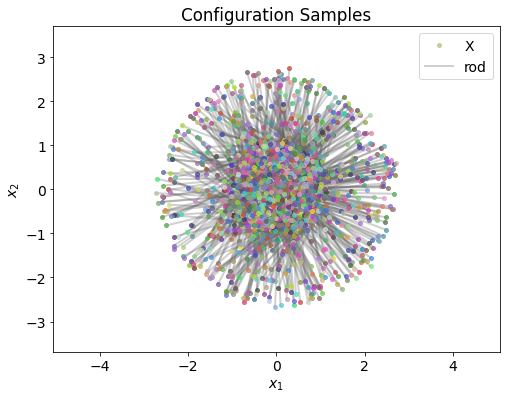

In [3]:
if flag_dataset == 'arm1_torus':
    flag_model_type = 'arm1';
    dgen_type = 'arm1_torus'; s_data['dgen_type'] = dgen_type;

    params_gen = {};
    num_samples = int(1e4); num_theta = 2;    
    params_gen = {'num_samples':num_samples,'num_dim':2,'num_theta':num_theta,'device':device};
    params_gen.update({'noise_type':'Gaussian1','params_noise':{'sigma':7.5e-2},'sample_mode':'with_noise'});
    ell_list = torch.ones(num_samples,num_theta,device=device); ell_list[:,0] = 1.0; ell_list[:,1] = 0.5;
    params_gen.update({'ell_list':ell_list});

    # create dataset and loaders 
    train_dataset = pkg.datasets.GenDataArm1Rigid(**params_gen,flag_verbose=0).to(device);
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True);

    test_dataset = pkg.datasets.GenDataArm1Rigid(**params_gen,flag_verbose=0).to(device);
    test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False);

    # plot
    pkg.vis.plot_arm1_data(train_dataset,base_dir);
    
elif flag_dataset == 'arm1_klein':
    flag_model_type = 'arm1';
    dgen_type = 'arm1_klein'; s_data['dgen_type'] = dgen_type;
    
    params_gen = {}; num_samples = int(3e3);
    params_klein = {'a':1.6,'b':1,'n1':200,'n2':200,'device':device};
    params_gen.update({'num_samples':num_samples,'num_dim':2,'num_dim_X':4,'params_klein':params_klein,'device':device});
    params_gen.update({'noise_type':'Gaussian1','params_noise':{'sigma':7.5e-2},'sample_mode':'with_noise'});    
        
    # create dataset and loaders
    train_dataset = pkg.datasets.GenDataArm1Klein(**params_gen,flag_verbose=0).to(device);
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True);

    test_dataset = pkg.datasets.GenDataArm1Klein(**params_gen,flag_verbose=0).to(device);
    test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False);

    # plot
    pkg.vis.plot_arm1_data(train_dataset,base_dir);      

else:
    raise Exception("Not recognized, flag_dataset = " + str(flag_dataset));

#### Setup Model and Neural Network Architectures

In [4]:
extra_params = {};
    
if flag_model == 'gd_vae_nn1_R_n':
  #num_dim_z = 4; # uses value from above

  manifold_map = None; # no manifold map, just use R^n latent space

  # -- theta (decoder)
  input_size = num_dim_z; output_size = num_dim_x;
  layer_sizes = [input_size,int(1e2),int(5e2),int(1e2),output_size]; layer_biases = [True,True,True,False];
  params_theta = {'layer_sizes':layer_sizes,'layer_biases':layer_biases,'manifold_map':manifold_map};

  # -- phi (encoder)
  input_size = num_dim_x; output_size = num_dim_z;
  layer_sizes = [input_size,int(1e2),int(5e2),int(1e2),output_size]; layer_biases = [True,True,True,False];
  params_phi = {'layer_sizes':layer_sizes,'layer_biases':layer_biases,'manifold_map':manifold_map};
  
  # -- general parameters
  type_model = 'gd_vae_nn1';  
  params_create = {}; params_create.update({'type_model':type_model,'params_theta':params_theta,
                                             'params_phi':params_phi,'device':device});
  model = pkg.model_utils.create_model(**params_create);
    
  theta = model['theta']; phi = model['phi'];
  
  print("theta (decoder):"); # decoder  
  print("manifold_map = " + str(params_theta['manifold_map']));
  print("model_mu = " + str(theta['model_mu']));
  print("model_log_sigma_sq = " + str(theta['model_log_sigma_sq']));

  print("phi (encoder):"); # decoder
  print("manifold_map = " + str(params_phi['manifold_map']));
  print("model_mu = " + str(phi['model_mu']));
  print("model_log_sigma_sq = " + str(phi['model_log_sigma_sq']));  

elif flag_model == 'gd_vae_nn1_torus':
  #num_dim_z = 4; # uses value from above

  # -- create manifold map to torus
  manifold_map = pkg.model_utils.create_manifold_map_torus(device=device);
  
  # -- theta (decoder)
  input_size = num_dim_z; output_size = num_dim_x;
  layer_sizes = [input_size,int(1e2),int(5e2),int(1e2),output_size]; layer_biases = [True,True,True,False];
  params_theta = {'layer_sizes':layer_sizes,'layer_biases':layer_biases,'manifold_map':manifold_map};

  # -- phi (encoder)
  input_size = num_dim_x; output_size = num_dim_z;
  layer_sizes = [input_size,int(1e2),int(5e2),int(1e2),output_size]; layer_biases = [True,True,True,False];
  params_phi = {'layer_sizes':layer_sizes,'layer_biases':layer_biases,'manifold_map':manifold_map};
  
  # -- general parameters
  type_model = 'gd_vae_nn1';      
  params_create = {}; params_create.update({'type_model':type_model,'params_theta':params_theta,
                                             'params_phi':params_phi,'device':device});
  model = pkg.model_utils.create_model(**params_create);
    
  theta = model['theta']; phi = model['phi'];
  
  print("theta (decoder):"); # decoder  
  print("manifold_map = " + str(params_theta['manifold_map']));
  print("model_mu = " + str(theta['model_mu']));
  print("model_log_sigma_sq = " + str(theta['model_log_sigma_sq']));

  print("phi (encoder):"); # decoder
  print("manifold_map = " + str(params_phi['manifold_map']));
  print("model_mu = " + str(phi['model_mu']));
  print("model_log_sigma_sq = " + str(phi['model_log_sigma_sq']));  

elif flag_model == 'gd_vae_nn1_klein':

  #num_dim_z = 4; # uses value from above

  # -- create manifold map to klein bottle 
  params_klein = {'a':1.6,'b':1,'n1':200,'n2':200,'device':device};
  manifold_map = pkg.model_utils.create_manifold_map_klein1(params_klein=params_klein,device=device);

  # -- theta (decoder)
  input_size = num_dim_z; output_size = num_dim_x;
  layer_sizes = [input_size,int(1e2),int(5e2),int(1e2),output_size]; layer_biases = [True,True,True,False];
  params_theta = {'layer_sizes':layer_sizes,'layer_biases':layer_biases,'manifold_map':manifold_map};  
  
  # -- phi (encoder)
  input_size = num_dim_x; output_size = num_dim_z;
  layer_sizes = [input_size,int(1e2),int(5e2),int(1e2),output_size]; layer_biases = [True,True,True,False];
  params_phi = {'layer_sizes':layer_sizes,'layer_biases':layer_biases,'manifold_map':manifold_map};
  
  # -- general parameters
  type_model = 'gd_vae_nn1';      
  params_create = {}; params_create.update({'type_model':type_model,'params_theta':params_theta,
                                            'params_phi':params_phi,'device':device});
  model = pkg.model_utils.create_model(**params_create);
    
  theta = model['theta']; phi = model['phi'];
  
  print("theta (decoder):"); # decoder    
  print("model_mu = " + str(theta['model_mu']));
  print("model_log_sigma_sq = " + str(theta['model_log_sigma_sq']));

  print("phi (encoder):"); # decoder  
  print("model_mu = " + str(phi['model_mu']));
  print("model_log_sigma_sq = " + str(phi['model_log_sigma_sq']));    
else:
  raise Exception("Not recognized, flag_model = " + flag_model);

# save the model specification
model_create_filename = '%s/model_params.pickle'%base_dir;
print("model_create_filename = " + model_create_filename);
fid = open(model_create_filename,'wb'); pickle.dump(params_create,fid); fid.close();

theta (decoder):
model_mu = Sequential(
  (0): Linear(in_features=4, out_features=100, bias=True)
  (1): LeakyReLU(negative_slope=1e-06)
  (2): Linear(in_features=100, out_features=500, bias=True)
  (3): LeakyReLU(negative_slope=1e-06)
  (4): Linear(in_features=500, out_features=100, bias=True)
  (5): LeakyReLU(negative_slope=1e-06)
  (6): Linear(in_features=100, out_features=4, bias=False)
  (7): ManifoldPointCloudLayer(ManifoldPointCloudLayer: params.keys() = dict_keys(['manifold_chart_I', 'manifold_chart_u', 'manifold_ptsX', 'find_manifold_pt', 'find_manifold_pt_params', 'get_manifold_sigma_info', 'get_manifold_sigma_info_params', 'kdtree', 'kdtree_params']))
)
model_log_sigma_sq = Sequential(
  (0): AtzLearnableTensorLayer(
    AtzLearnableTensorLayer:
    tensor.shape = torch.Size([1, 4])
    tensor.device = cuda:0
  )
)
phi (encoder):
model_mu = Sequential(
  (0): Linear(in_features=4, out_features=100, bias=True)
  (1): LeakyReLU(negative_slope=1e-06)
  (2): Linear(in_features=1

/home/atzberg/anaconda3/envs/pytorch37_1_10_1/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1644365692356/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
# setup additional parameters
extra_params.update({'m1_mc':100,'batch_size':batch_size,'total_N_xi':total_N_xi});
extra_params.update({'num_dim_x':num_dim_x,'num_dim_x_tilde':num_dim_x_tilde,'num_dim_z':num_dim_z});
extra_params.update({'n_tau':n_tau,'device':device,'return_extra_vals':{}}); # dictionary for returning extra values

print("extra_params:\n" + str(extra_params)); print("");
print("theta:\n" + str(theta)); print(""); print("phi:\n" + str(phi));

pkg.model_utils.init_model_arm1_pretrain_decoder1_init(theta,phi);
pkg.model_utils.save_model(theta,phi,type_model,'%s/model'%base_dir_training,'init');  

s_data.update({'flag_model_type':flag_model_type,'total_N_xi':total_N_xi,
               'num_dim_x':num_dim_x,'num_dim_z':num_dim_z,
               'extra_params':extra_params});

extra_params:
{'m1_mc': 100, 'batch_size': 1000, 'total_N_xi': 1000000, 'num_dim_x': 4, 'num_dim_x_tilde': 2, 'num_dim_z': 4, 'n_tau': 2, 'device': device(type='cuda', index=0), 'return_extra_vals': {}}

theta:
{'model_mu': Sequential(
  (0): Linear(in_features=4, out_features=100, bias=True)
  (1): LeakyReLU(negative_slope=1e-06)
  (2): Linear(in_features=100, out_features=500, bias=True)
  (3): LeakyReLU(negative_slope=1e-06)
  (4): Linear(in_features=500, out_features=100, bias=True)
  (5): LeakyReLU(negative_slope=1e-06)
  (6): Linear(in_features=100, out_features=4, bias=False)
  (7): ManifoldPointCloudLayer(ManifoldPointCloudLayer: params.keys() = dict_keys(['manifold_chart_I', 'manifold_chart_u', 'manifold_ptsX', 'find_manifold_pt', 'find_manifold_pt_params', 'get_manifold_sigma_info', 'get_manifold_sigma_info_params', 'kdtree', 'kdtree_params']))
), 'model_log_sigma_sq': Sequential(
  (0): AtzLearnableTensorLayer(
    AtzLearnableTensorLayer:
    tensor.shape = torch.Size([1, 4

KeyError: 'find_nearest_manifold_pt'

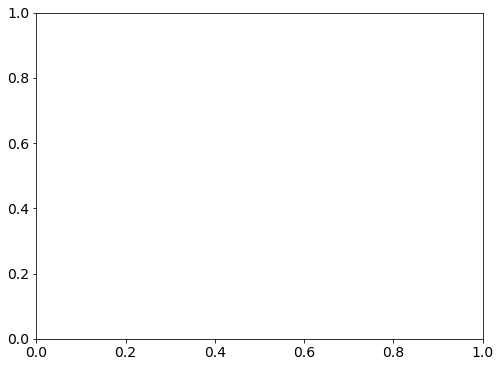

In [6]:
# display initial configuration and model prediction
X_batch = next(iter(train_loader)); # get first dataset batch  
fig_list, fig_names = pkg.vis.plot_model(theta,phi,X_batch,flag_model_type,
                                         flag_legends=True);

for (fig,fig_name) in zip(fig_list,fig_names):
  base_filename = '%s/initial_model_%s'%(base_dir,fig_name);
  gd_vae.utils.save_fig(base_filename,fig=fig,flag_pdf=True);

In [ ]:
flag_run_cell = True;
if flag_run_cell:
    model_log_sigma_sq = theta['model_log_sigma_sq'];
    p = model_log_sigma_sq[0]

    num_samples = 10; num_dim_x = 4;
    X = torch.zeros(num_samples,num_dim_x,device=device);
    X = X.requires_grad_(True);
    Y = p(X)

    loss = torch.sum(Y);

    loss.backward();
    
    print("Y.shape = " + str(Y.shape));

#### Train GD-VAE Model

In [ ]:
# setup training parameters
num_epochs = int(1e6); learning_rate = 1e-4;
#num_epochs = int(1e4); learning_rate = 1e-1;
flag_train_variance = False; flag_track_inter_terms = False; flag_track_weights_select = False;
flag_save_training_model = True; skip_save_training_model = int(1e3); flag_save_networks = True;
skip_save_network = int(1e2); flag_save_model_errors = True; skip_save_model_errors = int(1e2);

loss_list = np.empty(0); loss_step_list = np.empty(0); save_skip = 1; epoch = 0; display_skip = int(1e2);

extra_params['batch_size'] = batch_size;

s_data = {'num_epochs':num_epochs,'learning_rate':learning_rate,'flag_train_variance':flag_train_variance,
          'flag_track_inter_terms':flag_track_inter_terms,'flag_track_weights_select':flag_track_weights_select,          
          'extra_params':extra_params};

# save the parameter data for the run
print("Saving parameters"); print("");
filename_save_data = '%s/parameters.pickle'%base_dir;
print("filename_save_data = " + filename_save_data);
pickle.dump(s_data,open(filename_save_data,'wb'));

params_test_model_errors = {'base_dir_training':base_dir_training,
                            'ref_dataset':test_dataset,'device':device};

print(""); print("Training the network with:"); print("");

# setup the optimization method and loss function
# define the parameters over which we are optimizing
model_param_select = gd_vae.utils.DictAsMembers(pkg.model_utils.get_data_of_model_select(theta,phi,flag_model_type));

params_to_opt = [];
params_to_opt += list(phi['model_mu'].parameters()); # assumes is sequential, train the non-filter layer, mlp 1 assumed only part.
params_to_opt += list(theta['model_mu'].parameters()); 
print("theta['model_mu'] = " + str(theta['model_mu']));
print("phi['model_mu'] = " + str(phi['model_mu']));
if flag_train_variance:
  mm = phi['model_mu']; # note assumed Sequential type with filter layer first
  params_to_opt += list(phi['model_log_sigma_sq'].mlp.parameters()); # assumes is sequential, train the non-filter layer, mlp 1 assumed only part.
  params_to_opt += list(theta['model_log_sigma_sq'].parameters());  
  params_to_opt += list(theta['nu']); # not clear this is changed

optimizer = torch.optim.Adam(params_to_opt, lr=learning_rate);
print("optimizer = " + str(optimizer));    
    
# setup loss function
loss_func = gd_vae.vae.loss_VAE_neg_tilde_L_B;
print("loss_func = " + str(loss_func));
print("extra_params.keys() = " + str(extra_params.keys()));

In [ ]:
print("num_epochs = %d"%num_epochs); print("batch_size = %d"%batch_size); print(" ");

# train the model
flag_print_params = True; print("-"*80); num_steps = len(train_loader);
flag_quit = False; step_count = 0;
while flag_quit is False:
    for i, X_batch in enumerate(train_loader):
        
        # compute loss
        loss = loss_func(X_batch,theta,phi,**extra_params);

        # display
        if step_count % save_skip == 0:
          np_loss   = loss.cpu().detach().numpy();
          loss_list = np.append(loss_list,np_loss);
          loss_step_list = np.append(loss_step_list,step_count);

        # back-propagation for gradients and use to optimize
        optimizer.zero_grad(); loss.backward(); optimizer.step();
        
        # display and plot results of the step
        if (step_count % display_skip) == 0:
          msg = 'epoch: [%d/%d]; '%(epoch+1,num_epochs);
          msg += 'batch_step = [%d/%d]; '%(i + 1,num_steps);
          msg += 'loss: %.3e.'%(loss.item());
          print(msg);

          if flag_print_params:            
            pkg.model_utils.print_params_select(theta,phi,flag_model_type);
          
          if flag_print_params:            
            print("."*80); 

        # save information related to the training
        if flag_track_inter_terms: # track terms in loss function for learning dynamics
          D_KL_q_phi_z_x__p_theta_z = extra_params['return_extra_vals']['D_KL_q_phi_z_x__p_theta_z'];
          avg_sum_log_p_theta__x__z = extra_params['return_extra_vals']['avg_sum_log_p_theta__x__z']; 
                    
        if flag_save_training_model and (step_count % skip_save_training_model == 0):
          filename = '%s/training_model_select_%.8d.pickle'%(base_dir_training,step_count);
          print("filename = " + filename);
          model_param_select = pkg.model_utils.get_data_of_model_select(theta,phi,flag_model_type);
          f = open(filename,'wb'); pickle.dump(model_param_select,f); f.close();
            
        if flag_save_model_errors and (step_count % skip_save_model_errors == 0):               
          print("Computing model errors.");
          params_test_model_errors.update({'step_count':step_count,'sigma_list':[1e-2,5e-2,1e-1,5e-1]});
          pkg.model_utils.test_model_errors(theta,phi,**params_test_model_errors);
                                            
        if flag_save_networks  and (step_count % skip_save_network == 0):
          pkg.model_utils.save_model(theta,phi,type_model,'%s/model'%base_dir_training,'%.7d'%step_count);  
        
        # update count of training steps
        step_count += 1; 
        if step_count > num_epochs:
          flag_quit = True;

print("done training."); print("-"*80);

#### Show Prediction of the Learned Model

In [ ]:
# show prediction of the trained model
flag_run_cell = True;
if flag_run_cell:  
  input = next(iter(train_loader)); # get first dataset batch  

  fig_list, fig_names = pkg.vis.plot_model(theta,phi,input,flag_model_type,flag_legends=True);
  
  for (fig,fig_name) in zip(fig_list,fig_names):
    base_filename = '%s/learned_model_%s'%(base_dir,fig_name);
    gd_vae.utils.save_fig(base_filename,fig=fig);